KeyboardInterrupt: 

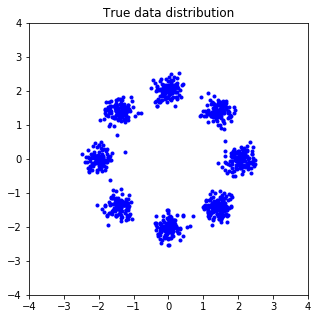

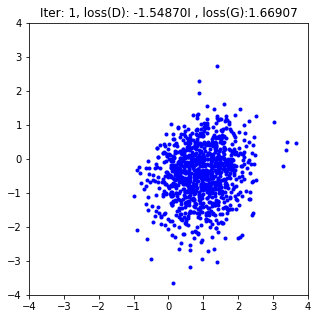

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
import random
import sys
%matplotlib inline

from IPython import display

def gaussians_8mode(sample_size):
    scale = 2.
    centers = [
        (1,0),
        (-1,0),
        (0,1),
        (0,-1),
        (1./np.sqrt(2), 1./np.sqrt(2)),
        (1./np.sqrt(2), -1./np.sqrt(2)),
        (-1./np.sqrt(2), 1./np.sqrt(2)),
        (-1./np.sqrt(2), -1./np.sqrt(2))
    ]
    centers = [(scale*x,scale*y) for x,y in centers]
    dataset = []
    for i in range(sample_size):
        point = np.random.randn(2)*.2
        center = random.choice(centers)
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype='float32')
    return dataset





model      = 'dan_energy_batch' # One of: [dan_s, dan_energy_batch]
batch_size = 512
Z_dim      = 256
s_lambda =1
s_iter = 100

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_h3 = tf.nn.relu(tf.matmul(G_h2, G_W3) + G_b3)
    G_logit = tf.matmul(G_h3, G_W4) + G_b4
    return G_logit

def gan_discriminator(x_real, x_fake):
    """ I.e. Regular GAN discriminator """
    D_h1_real = tf.nn.relu(tf.matmul(x_real / 4, D_W1) + D_b1)
    D_h2_real = tf.nn.relu(tf.matmul(D_h1_real, D_W2) + D_b2)
    D_h3_real = tf.nn.relu(tf.matmul(D_h2_real, D_W3) + D_b3)
    D_logit_real = tf.matmul(D_h3_real, D_W4) + D_b4
    D_prob_real = tf.nn.sigmoid(D_logit_real)

    D_h1_fake = tf.nn.relu(tf.matmul(x_fake / 4, D_W1) + D_b1)
    D_h2_fake = tf.nn.relu(tf.matmul(D_h1_fake, D_W2) + D_b2)
    D_h3_fake = tf.nn.relu(tf.matmul(D_h2_fake, D_W3) + D_b3)
    D_logit_fake = tf.matmul(D_h3_fake, D_W4) + D_b4
    D_prob_fake = tf.nn.sigmoid(D_logit_fake)    
    return D_prob_real, D_logit_real, D_prob_fake, D_logit_fake


def gan_energy_discriminator(x_real1, x_real2, x_fake1, x_fake2):
    """ I.e. Regular GAN discriminator """
    D_h1_real1 = tf.nn.relu(tf.matmul(x_real1 / 4, D_W1) + D_b1)
    D_h2_real1 = tf.nn.relu(tf.matmul(D_h1_real1, D_W2) + D_b2)
    D_h3_real1 = tf.nn.relu(tf.matmul(D_h2_real1, D_W3) + D_b3)
    D_logit_real1 = tf.matmul(D_h3_real1, D_W4) + D_b4
    # D_logit_real1 = tf.nn.l2_normalize(D_logit_real1, dim=1)
    
    
    D_h1_real2 = tf.nn.relu(tf.matmul(x_real2 / 4, D_W1) + D_b1)
    D_h2_real2 = tf.nn.relu(tf.matmul(D_h1_real2, D_W2) + D_b2)
    D_h3_real2 = tf.nn.relu(tf.matmul(D_h2_real2, D_W3) + D_b3)
    D_logit_real2 = tf.matmul(D_h3_real2, D_W4) + D_b4
    # D_logit_real2 = tf.nn.l2_normalize(D_logit_real2, dim=1)


    D_h1_fake1 = tf.nn.relu(tf.matmul(x_fake1 / 4, D_W1) + D_b1)
    D_h2_fake1 = tf.nn.relu(tf.matmul(D_h1_fake1, D_W2) + D_b2)
    D_h3_fake1 = tf.nn.relu(tf.matmul(D_h2_fake1, D_W3) + D_b3)
    D_logit_fake1 = tf.matmul(D_h3_fake1, D_W4) + D_b4
    # D_logit_fake1 = tf.nn.l2_normalize(D_logit_fake1, dim=1)
    
    
    D_h1_fake2 = tf.nn.relu(tf.matmul(x_fake2 / 4, D_W1) + D_b1)
    D_h2_fake2 = tf.nn.relu(tf.matmul(D_h1_fake2, D_W2) + D_b2)
    D_h3_fake2 = tf.nn.relu(tf.matmul(D_h2_fake2, D_W3) + D_b3)
    D_logit_fake2 = tf.matmul(D_h3_fake2, D_W4) + D_b4
    # D_logit_fake2 = tf.nn.l2_normalize(D_logit_fake2, dim=1)
    
    
   
    return D_logit_real1, D_logit_real2,  D_logit_fake1, D_logit_fake2


def dan_s_discriminator(x_real, x_fake):
    """ A.k.a Sample classifier for DAN_S"""
    D_h1_real = tf.nn.relu(tf.matmul(x_real / 4, D_W1) + D_b1)
    D_h2_real = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_real, D_W2) + D_b2), axis=0, keep_dims=True)
    D_h3_real = tf.nn.relu(tf.matmul(D_h2_real, D_W3) + D_b3)
    D_logit_real = tf.matmul(D_h3_real, D_W4) + D_b4
    D_prob_real = tf.nn.sigmoid(D_logit_real)

    D_h1_fake = tf.nn.relu(tf.matmul(x_fake / 4, D_W1) + D_b1)
    D_h2_fake = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_fake, D_W2) + D_b2), axis=0, keep_dims=True)
    D_h3_fake = tf.nn.relu(tf.matmul(D_h2_fake, D_W3) + D_b3)
    D_logit_fake = tf.matmul(D_h3_fake, D_W4) + D_b4
    D_prob_fake = tf.nn.sigmoid(D_logit_fake)

    return D_prob_real, D_logit_real, D_prob_fake, D_logit_fake
                        

def sample_Z(m, n):
    return np.random.normal(size=[m, n])


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# Set up weights
D_W1 = tf.Variable(xavier_init([2, 32]))
D_b1 = tf.Variable(tf.zeros(shape=[32]))

D_W2 = tf.Variable(xavier_init([32, 32]))
D_b2 = tf.Variable(tf.zeros(shape=[32]))

D_W3 = tf.Variable(xavier_init([32, 32]))
D_b3 = tf.Variable(tf.zeros(shape=[32]))

if model in ['dan_energy_batch']:
    D_W4 = tf.Variable(xavier_init([32, 32]))
    D_b4 = tf.Variable(tf.zeros(shape=[32]))
else:
    D_W4 = tf.Variable(xavier_init([32, 1]))
    D_b4 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3, D_W4, D_b4]

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 128]))
G_b2 = tf.Variable(tf.zeros(shape=[128]))

G_W3 = tf.Variable(xavier_init([128,128]))
G_b3 = tf.Variable(tf.zeros(shape=[128]))

G_W4 = tf.Variable(xavier_init([128, 2]))
G_b4 = tf.Variable(tf.zeros(shape=[2]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3, G_W4, G_b4]


# Set up variables
if model in ['gan', 'dan_s']:
    # Only one sample in this case
    X = tf.placeholder(tf.float32, shape=[None, 2])
    Z = tf.placeholder(tf.float32, shape=[None, Z_dim])    
    G_sample = generator(Z)    
    if model == 'gan':
        D_prob_real, D_logit_real, D_prob_fake, D_logit_fake = gan_discriminator(X, G_sample)    
    else:
        D_prob_real, D_logit_real, D_prob_fake, D_logit_fake = dan_s_discriminator(X, G_sample)    
        
else:
    # One variable per sample
    X_1 = tf.placeholder(tf.float32, shape=[None, 2])
    X_2 = tf.placeholder(tf.float32, shape=[None, 2])
    Z_1 = tf.placeholder(tf.float32, shape=[None, Z_dim])
    Z_2 = tf.placeholder(tf.float32, shape=[None, Z_dim])
    G_sample_1 = generator(Z_1)
    G_sample_2 = generator(Z_2)
    if model =='dan_energy_batch':
        D_logit_real1, D_logit_real2,  D_logit_fake1, D_logit_fake2 = gan_energy_discriminator(X_1, X_2, G_sample_1, G_sample_2)
 
        
# Set up losses
if model in ['gan', 'dan_s']:
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
else:
    if model == 'dan_energy_batch':
        batch_logit_real1 = tf.reduce_mean(D_logit_real1, axis=0)
        batch_logit_real2 = tf.reduce_mean(D_logit_real2, axis=0)
        batch_logit_fake1 = tf.reduce_mean(D_logit_fake1, axis=0)
        batch_logit_fake2 = tf.reduce_mean(D_logit_fake2, axis=0)
        D_logit_11 = tf.norm(batch_logit_real1 - batch_logit_real2)
        D_logit_10 = tf.norm(batch_logit_real1 - batch_logit_fake2)
        D_logit_01 = tf.norm(batch_logit_fake1 - batch_logit_real2)
        D_logit_00 = tf.norm(batch_logit_fake1 - batch_logit_fake2)
        D_loss = -(D_logit_01 + D_logit_10 - D_logit_00 - D_logit_11)
        G_loss = D_logit_01 + D_logit_10 - D_logit_00

    else:
        raise NotImplementedError
        


# Set up solvers
D_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5).minimize(G_loss, var_list=theta_G)




data = gaussians_8mode(40000)
data_size = len(data)
data = np.concatenate((data, data[:batch_size,:]), axis=0)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


save_fig_path = 'out_' + model
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)

i = 0

plt.figure(figsize=(5,5))
plt.plot(data[:1000,0], data[:1000,1], 'b.')
axes = plt.gca()
axes.set_xlim([-4,4])
axes.set_ylim([-4,4])
plt.title('True data distribution')
plt.savefig(save_fig_path + '/real.png', bbox_inches='tight')



from IPython import display
np_samples = []
plot_every = 500
plt.figure(figsize=(5,5))
D_loss_curr = 0
G_loss_curr = 0

print('Start Training')
sys.stdout.flush()
for it in range(40000):
    start_idx = it*batch_size%data_size
    X_mb = data[start_idx:start_idx+batch_size, :]
    
    
    if it<15000:
        if model in ['gan', 'dan_s']:
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(batch_size, Z_dim)})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: sample_Z(batch_size, Z_dim)})
        elif model in ['dan_energy_batch', 'dan_2s']:
            sample_size = int(batch_size/2)
            if (it+1) % 1 == 0:
                _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X_1: X_mb[:sample_size,:], \
                                X_2: X_mb[sample_size:,:], \
                                Z_1: sample_Z(sample_size, Z_dim), \
                                Z_2: sample_Z(sample_size, Z_dim)})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={ \
                            X_1: X_mb[:sample_size,:], \
                            X_2: X_mb[sample_size:,:], \
                            Z_1: sample_Z(sample_size, Z_dim), \
                            Z_2: sample_Z(sample_size, Z_dim)})
    else:
        if model in ['gan', 'dan_s']:
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: sample_Z(batch_size, Z_dim)})
        elif model in ['dan_energy_batch']:
            sample_size = int(batch_size/2)
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={ \
                            X_1: X_mb[:sample_size,:], \
                            X_2: X_mb[sample_size:,:], \
                            Z_1: sample_Z(sample_size, Z_dim), \
                            Z_2: sample_Z(sample_size, Z_dim)})



    if (it+1) % plot_every == 0 or it==0:
        if model in ['gan', 'dan_s']:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(1000, Z_dim)})
        else:
            samples = sess.run(G_sample_1, feed_dict={Z_1: sample_Z(1000, Z_dim)})

        np_samples.append(samples)
        plt.clf()
        plt.plot(samples[:,0], samples[:,1], 'b.')
        axes = plt.gca()
        axes.set_xlim([-4,4])
        axes.set_ylim([-4,4])
        if model=='dan_wgan':
            plt.title('Iter: {}, loss(D): {:2.5f}, loss(G):{:2.5f}, entropy:{:2.5f}'.format(it+1, D_loss_curr, G_loss_curr, entropy_np))
        else:
            plt.title('Iter: {}, loss(D): {:2.5f}I , loss(G):{:2.5f}'.format(it+1, D_loss_curr, G_loss_curr))
        plt.savefig('out_' + model + '/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')        
        display.display(plt.gcf()) 
        display.clear_output(wait=True)
        i += 1
        